In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt

In [121]:
RESULTS_DATABASE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/P3856/summarised-results/results.sqlite'

In [122]:
db_conn = sqlite3.connect(RESULTS_DATABASE_NAME)
results_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [123]:
len(results_df)

23295

In [124]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [125]:
results_df.iloc[0].identifications_d

{'perc_q_value': 0.0079911972,
 'run_names': ['P3856_YHE114_2_Slot1-1_1_5116'],
 'number_of_runs': 1,
 'proteins': ['sp|P19338|NUCL_HUMAN'],
 'number_of_proteins': 1}

In [126]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_protein_count'] = results_df.apply(lambda row: row.identifications_d['number_of_proteins'], axis=1)
results_df['id_protein'] = results_df.apply(lambda row: row.identifications_d['proteins'][0], axis=1)
results_df['id_human'] = results_df.apply(lambda row: 'HUMAN' in row.id_protein.upper(), axis=1)

In [127]:
# remove the results that couldn't be extracted or were not classified as a target
results_df = results_df[results_df.extractions.notnull()].copy()

In [128]:
# convert from JSON to Python objects
results_df['extractions_l'] = results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [129]:
results_df.sample(n=2)

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_protein_count,id_protein,id_human,extractions_l
11720,LLDILSYLR,2,"{""perc_q_value"": 0.00010311984, ""run_names"": [...","[{""run_name"": ""P3856_YHE010_9_Slot1-1_1_5101"",...","{'perc_q_value': 0.00010311984, 'run_names': [...",0.000103,8,1,sp|O15091|MRPP3_HUMAN,True,"[{'run_name': 'P3856_YHE010_9_Slot1-1_1_5101',..."
8070,HCVTFVLHEEDHTLGNSLR,4,"{""perc_q_value"": 3.817231e-06, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 3.817231e-06, 'run_names': ['...",0.000004,7,1,sp|P0DPB6|RPAC2_HUMAN,True,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',..."


In [130]:
def groups_from_runs(run_names_l):
    groups_l = [r.split('_')[1] for r in run_names_l]
    return list(set(groups_l))

In [131]:
# return True if we can include an extraction from the specified group, given the groups in which it was identified
# need to implement these rules differently for each experiment, probably best with a simple rules parameter file
def extract_from_group(extract_group, identification_groups_l):
    result = False
    if extract_group == 'YHE010':
        result = extract_group in identification_groups_l
    else:
        result = True
    return result

In [132]:
# expand the extractions to a row for each - only extract it if it was identified in the group
sequences_l = []
for row in results_df.itertuples():
    for group_name in ['YHE010','YHE114','YHE211']:
        if extract_from_group(group_name, groups_from_runs(row.identifications_d['run_names'])):
            for extraction in row.extractions_l:
                if group_name in extraction['run_name']:
                    short_run_name = '_'.join(extraction['run_name'].split('_Slot')[0].split('_')[1:])
                    sequences_l.append((row.sequence, row.charge, row.id_perc_q_value, short_run_name, group_name, extraction['intensity'], row.id_protein, row.id_human))
sequences_df = pd.DataFrame(sequences_l, columns=['sequence', 'charge', 'id_perc_q_value', 'short_run_name', 'group','intensity','protein','human'])


In [133]:
sequences_df.sample(n=2)

,sequence,charge,id_perc_q_value,short_run_name,group,intensity,protein,human
213894,IAQLEEELEEEQSNMELLNDR,2,0.000004,YHE114_3,YHE114,278,sp|P35580|MYH10_HUMAN,True
504052,VLEGHTDFINGLVFDPK,2,0.000004,YHE114_8,YHE114,1034,sp|Q8NFH4|NUP37_HUMAN,True


#### analyse the YHE runs

In [134]:
yhe_only_df = sequences_df[(sequences_df.group == 'YHE114') | (sequences_df.group == 'YHE211')]

In [135]:
number_of_yhe_runs_in_experiment = len(yhe_only_df.short_run_name.unique())
print('there are {} YHE runs in the experiment'.format(number_of_yhe_runs_in_experiment))

there are 20 YHE runs in the experiment


In [136]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in yhe_only_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.short_run_name.unique()), group_name[0], group_name[1]))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_targets_extracted','sequence','charge'])

In [137]:
# display the number of missing values across the experiment
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_targets_extracted
proportion_of_missing_values = yhe_sequence_occurences_df.missing_files.sum() / (len(yhe_sequence_occurences_df) * number_of_yhe_runs_in_experiment)
print("{}% of values are missing across the YHE-only runs.".format(round(proportion_of_missing_values*100)))

9.0% of values are missing across the YHE-only runs.


In [138]:
yhe_sequence_occurences_df.sample(n=5)[['sequence','charge','number_of_runs_targets_extracted','missing_files']]

,sequence,charge,number_of_runs_targets_extracted,missing_files
9156,IGSSELQEFCPTILQQLDSR,2,20,0
20366,VGDSTPVSEKPVSAAVDANASESP,2,20,0
18591,TESQWENTEAPVSYK,2,20,0
4892,EQQEAIEHIDEVQNEIDRLNEQASEEILK,4,20,0
1324,AQGVLFDCDGVLWNGER,2,20,0


In [139]:
unique_sequences_yhe_df = yhe_only_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
number_of_unique_sequences_yhe = len(unique_sequences_yhe_df)
number_of_unique_sequences_yhe

22715

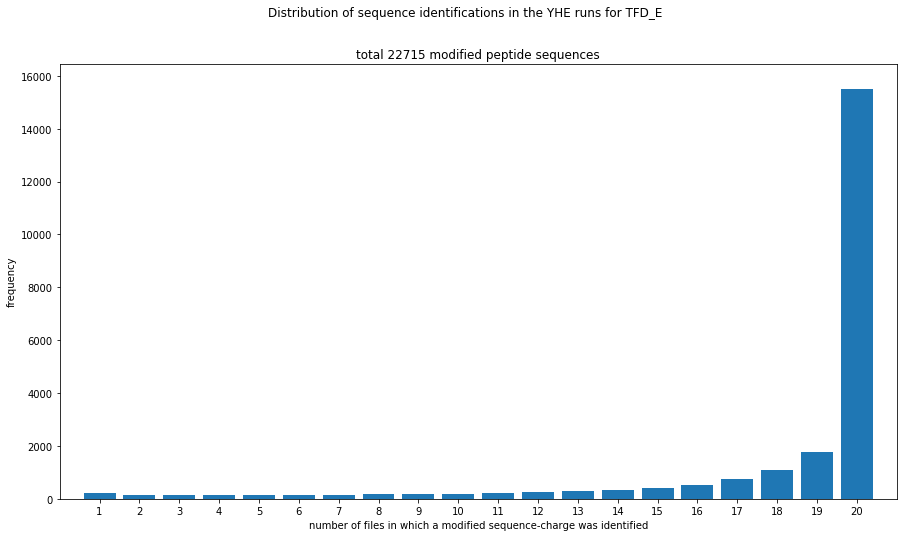

In [140]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the YHE runs for TFD_E')
plt.title('total {} modified peptide sequences'.format(number_of_unique_sequences_yhe))

counts = np.bincount(yhe_sequence_occurences_df.number_of_runs_targets_extracted)
ax1.bar(range(number_of_yhe_runs_in_experiment+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_yhe_runs_in_experiment+1), xlim=[0, number_of_yhe_runs_in_experiment+1])
# plt.ylim((0,12000))

plt.show()

#### now analyse the HeLa-only runs

In [141]:
human_only_df = sequences_df[(sequences_df.group == 'YHE010')]

In [142]:
human_only_df.columns

Index(['sequence', 'charge', 'id_perc_q_value', 'short_run_name', 'group',
       'intensity', 'protein', 'human'],
      dtype='object')

In [143]:
number_of_human_runs_in_experiment = len(human_only_df.short_run_name.unique())
print('there are {} HeLa runs in the experiment'.format(number_of_human_runs_in_experiment))

there are 10 HeLa runs in the experiment


In [144]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in human_only_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.short_run_name.unique()), group_name[0], group_name[1], group_df.iloc[0].human))
human_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_targets_extracted','sequence','charge','human'])

In [145]:
# display the number of missing values across the experiment
human_sequence_occurences_df['missing_files'] = number_of_human_runs_in_experiment - human_sequence_occurences_df.number_of_runs_targets_extracted
proportion_of_missing_values = human_sequence_occurences_df.missing_files.sum() / (len(human_sequence_occurences_df) * number_of_human_runs_in_experiment)
print("{}% of values are missing across the HeLa-only runs.".format(round(proportion_of_missing_values*100)))

6.0% of values are missing across the HeLa-only runs.


In [146]:
# proportion of false positives i.e. non-human peptides found in the human-only runs
print('false positives: {}%'.format(round(len(human_sequence_occurences_df[(human_sequence_occurences_df.human == False)]) / len(human_sequence_occurences_df) * 100.0, 1)))

false positives: 2.1%


In [147]:
human_sequence_occurences_df[(human_sequence_occurences_df.human == False)].sample(n=5)

,sequence_charge,number_of_runs_targets_extracted,sequence,charge,human,missing_files
8451,"(LVSGEATPINMTNHTYFNLNK, 3)",7,LVSGEATPINMTNHTYFNLNK,3,False,3
14452,"(WNLDRDLLFR, 2)",8,WNLDRDLLFR,2,False,2
1282,"(CLVMLPFVDPMAR, 2)",10,CLVMLPFVDPMAR,2,False,0
5592,"(HQYDYDAATVYGFLK, 2)",7,HQYDYDAATVYGFLK,2,False,3
13026,"(TTLLDILAMK, 2)",3,TTLLDILAMK,2,False,7


In [148]:
human_sequence_occurences_df.sample(n=5)[['sequence','charge','number_of_runs_targets_extracted','missing_files']]

,sequence,charge,number_of_runs_targets_extracted,missing_files
6385,IPGTDAQAQAEDMNVK,2,10,0
321,AGDQIICM[15.9949]DDVYGGTNR,2,10,0
1264,CLELFSELAEDKENYK,3,10,0
12806,TPETAEFLGEDLLQVEQR,2,10,0
550,ALGVHSMNDFR,2,6,4


In [149]:
unique_sequences_human_df = human_only_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False)
number_of_unique_sequences_human = len(unique_sequences_human_df)
number_of_unique_sequences_human

15085

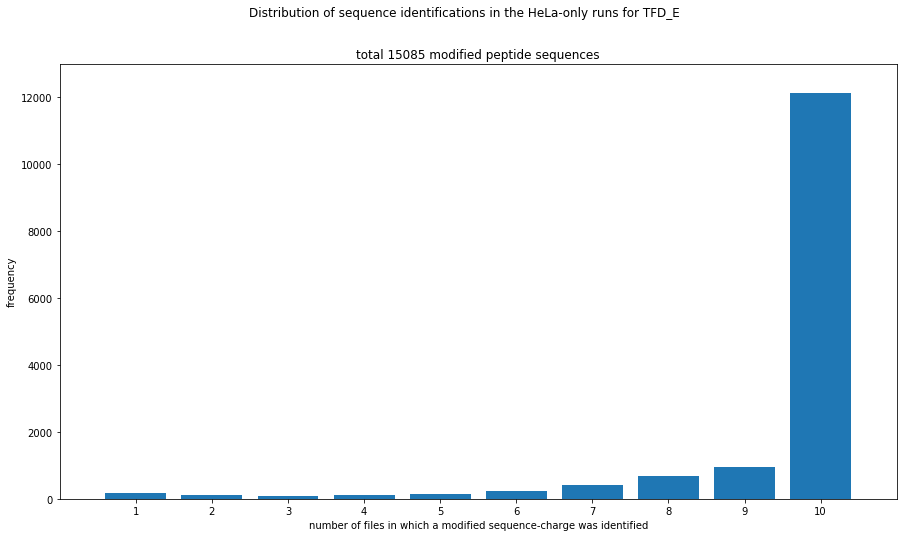

In [150]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the HeLa-only runs for TFD_E')
plt.title('total {} modified peptide sequences'.format(number_of_unique_sequences_human))

counts = np.bincount(human_sequence_occurences_df.number_of_runs_targets_extracted)
ax1.bar(range(11), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,11), xlim=[0, 11])
plt.ylim((0,13000))

plt.show()

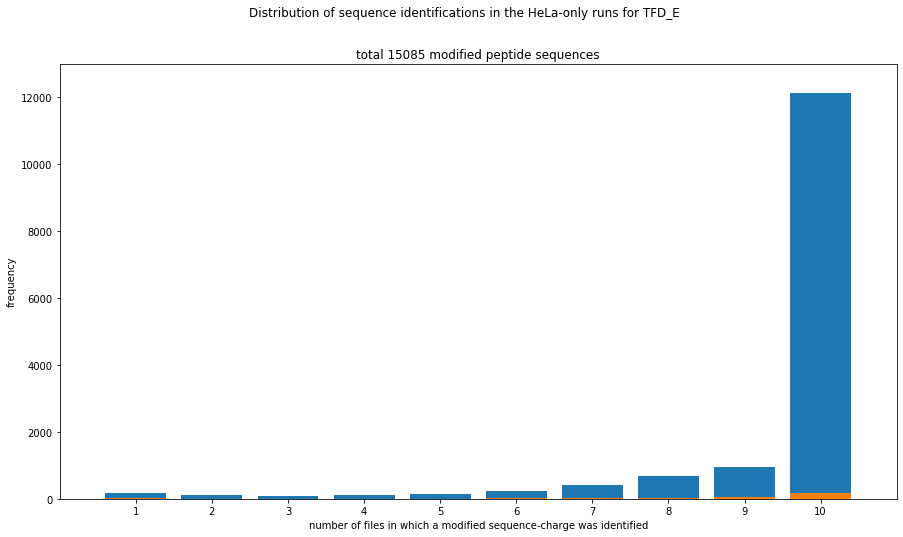

In [151]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the HeLa-only runs for TFD_E')
plt.title('total {} modified peptide sequences'.format(number_of_unique_sequences_human))

counts_human = np.bincount(human_sequence_occurences_df[human_sequence_occurences_df.human == True].number_of_runs_targets_extracted)
counts_other = np.bincount(human_sequence_occurences_df[human_sequence_occurences_df.human == False].number_of_runs_targets_extracted)

ax1.bar(range(11), counts_human, bottom=counts_other, width=0.8, align='center')
ax1.bar(range(11), counts_other, width=0.8, align='center')

plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,11), xlim=[0, 11])
plt.ylim((0,13000))

plt.show()